In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft, fftfreq, fftshift
import math
import matplotlib.ticker as ticker
from scipy.special import erf
from matplotlib import gridspec

def E_of_t_laser(fwhm, t, t_0, w_0):
    return np.exp((-2*math.log(2)*((t - t_0)**2))/(fwhm**2))*np.exp(-1j*w_0*t)

fwhm = 10
c = 299792458
w_0 = 2*np.pi*c*1e-15/800e-9
print(w_0*2)
t_0 = 200000
Npts = 2**19
ts = np.linspace(0, 400000, Npts)
dt = ts[1] - ts[0]
Es = E_of_t_laser(fwhm, ts, t_0, w_0)

4.709128918272134


In [2]:
'''
Mathematica's Fourier transform uses a positively-signed (clockwise-spinned) exponent, whereas
Python uses a negatively-signed exponent. This has the effect of conjugating the input and output,
so we use np.conj to get results matching Mathematica

norm = 'ortho' scales both forward and backward transforms by 1/sqrt(N) (N number of points)
'''
Ews = np.conj(fft(np.conj(Es), norm = 'ortho'))

#matching Mathematica code way to get ws
ws = 2 * np.pi * np.arange(Npts) / (Npts * dt)

Ews_power = np.abs(Ews)**2
maxU = np.max(Ews_power)

print(ws[-1])

8.23546522992985


In [3]:
def chirper(Ews, phi):
    return Ews*np.exp(1j*phi)

def lin_chirp(A, w, w_0):
    return A*((w - w_0)**2)

#erf chirp from the mathematica code
def erf_chirp(B, w, w_0, sigma):
    x = (w - w_0)*2*sigma/math.sqrt(2*math.log(256))
    return B*((np.exp(-x**2) - 1)/math.sqrt(np.pi) + x*erf(x))

#super erf chirp from mathematica code 
def superf_chirp(C, w, w_0, sigma_s):
    x = (w - w_0)*2*sigma_s / math.sqrt(2*math.log(256))
    return C*((np.exp(-x**2) - 1)/math.sqrt(np.pi) + x*erf(x))

A = 180337
B = 8300
C = 7450

sigma_s = 1.12*fwhm #she had this hardcoded in to her super erf function

pos_lin = lin_chirp(A, ws, w_0)
neg_lin = lin_chirp(-A, ws, w_0)

pos_erf = erf_chirp(B, ws, w_0, fwhm)
neg_erf = erf_chirp(-B, ws, w_0, fwhm)

pos_superf = superf_chirp(C, ws, w_0, sigma_s)
neg_superf = superf_chirp(-C, ws, w_0, sigma_s)

ws_centered = ws - w_0
power_norm = Ews_power / maxU 

# Zoom in: find center index and plot surrounding region
i_center = np.argmin(np.abs(ws - w_0))
window = 2 * 17651
i_start = max(i_center - window, 0)
i_end = min(i_center + window, len(ws))

Ec_lin = chirper(Ews, pos_lin)
Ea_lin = chirper(Ews, neg_lin)

Ec_erf = chirper(Ews, pos_erf)
Ea_erf = chirper(Ews, neg_erf)

Ec_superf = chirper(Ews, pos_superf)
Ea_superf = chirper(Ews, neg_superf)

Ec_lin_t = np.conj(ifft(np.conj(Ec_lin), norm = 'ortho'))
Ec_erf_t = np.conj(ifft(np.conj(Ec_erf), norm = 'ortho'))
Ec_superf_t = np.conj(ifft(np.conj(Ec_superf), norm = 'ortho'))

In [4]:
def Ereffer(Ec, Ea, w, tau):
    return (Ec + Ea)*np.exp(1j*w*tau)

def Esampler(Ec, Ea, phi):
    return (Ec - Ea)*np.exp(1j*phi)

#need to calculate these in frequency domain, then ifft into time domain
taus = np.arange(-25, 25 + 0.5, 0.5)
#taus = np.arange(0, 200 + 0.5, 0.5)

def CPI(Ec, Ea, ws, taus, phi):
    Esamp_w = Esampler(Ec, Ea, phi)
    Esamp_t = np.conj(ifft(np.conj(Esamp_w), norm = 'ortho'))

    SFG_data = np.empty((len(taus), len(ws)))

    for i, tau in enumerate(taus):
        Eref_w = Ereffer(Ec, Ea, ws, tau)
        Esfg_t = np.conj(ifft(np.conj(Eref_w), norm = 'ortho'))*Esamp_t
        Esfg_w = np.conj(fft(np.conj(Esfg_t), norm = 'ortho'))
        Isfg_w = np.abs(Esfg_w)**2
        SFG_data[i, :] = Isfg_w

    return SFG_data

C:\Users\Berjoska\AppData\Local\Temp\ipykernel_15488\4289249788.py:23: RuntimeWarning: invalid value encountered in sqrt
  k_w = w*(np.sqrt(1 + (b1*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c1) +
C:\Users\Berjoska\AppData\Local\Temp\ipykernel_15488\4289249788.py:76: RankWarning: Polyfit may be poorly conditioned
  fit3 = np.polyfit(ws[idx], k_w[idx], 6)


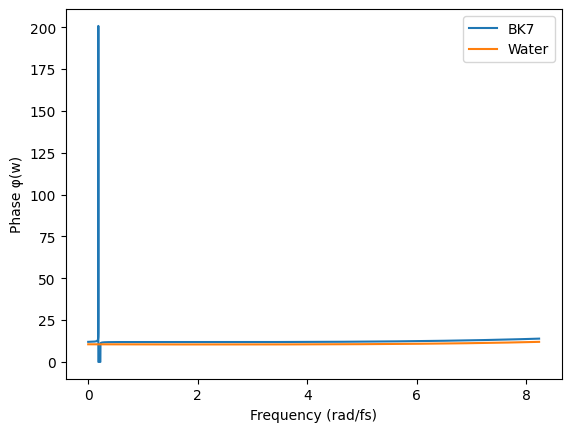

In [48]:
'''
w_0 = 2*np.pi*c*1e-15/800e-9
Npts = 2**19
ts = np.linspace(0, 400000, Npts)
dt = ts[1] - ts[0]
ws = 2 * np.pi * np.arange(Npts) / (Npts * dt)
'''
ws[0] = 1e-6


def BK7_epsilon(w, w0):
    c = 0.2998; #(*um/fs*)
    b1 = 1.03961212; #(*for BK7 glass*)
    b2 = 0.231792344
    b3 = 1.01046945
    c1 = 6.00069867e-3 #(*um^2*)
    c2 = 2.00179144e-2
    c3 = 1.03560653e2

    
    lambdas = (2 * np.pi * c / w) * 1e3

    k_w = w*(np.sqrt(1 + (b1*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c1) + 
                     (b2*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c2) + 
                     (b3*(2*np.pi*c/w)**2)/((2*np.pi*c/w)**2 - c3)))/c
    
    k_deriv = np.sqrt(1 +((4*b1*(c**2)*(np.pi**2))/(-c1*(w0**2) + (2*c*np.pi)**2)) + 
                      ((4*b2*(c**2)*(np.pi**2))/(-c2*(w0**2) + (2*c*np.pi)**2)) + 
                      ((4*b3*(c**2)*(np.pi**2))/(-c3*(w0**2) + (2*c*np.pi)**2)))/c + w0*(
                          (32*b1*(c*np.pi)**4)/((w0**5)*((-c1 + ((2*c*np.pi)**2)/(w0**2))**2)) +
                          (32*b2*(c*np.pi)**4)/((w0**5)*((-c2 + ((2*c*np.pi)**2)/(w0**2))**2)) +
                          (32*b3*(c*np.pi)**4)/((w0**5)*((-c3 + ((2*c*np.pi)**2)/(w0**2))**2)) -
                          (8*b1*(c*np.pi)**2)/((w0**3)*(-c1 + ((2*c*np.pi)**2)/(w0**2))) -
                          (8*b2*(c*np.pi)**2)/((w0**3)*(-c2 + ((2*c*np.pi)**2)/(w0**2))) -
                          (8*b3*(c*np.pi)**2)/((w0**3)*(-c3 + ((2*c*np.pi)**2)/(w0**2))))/(
                              2*c*np.sqrt(1 + (b1*(2*np.pi*c/w0)**2)/((2*np.pi*c/w0)**2 - c1) + 
                                          (b2*(2*np.pi*c/w0)**2)/((2*np.pi*c/w0)**2 - c2) + 
                                          (b3*(2*np.pi*c/w0)**2)/((2*np.pi*c/w0)**2 - c3)))


    idx = np.logical_and(ws > w0 - 0.1, ws < w0 + 0.1)  # Narrow window around w₀
    fit = np.polyfit(ws[idx], k_w[idx], 1)     # Linear fit

    phi_bk7 = k_w - k_deriv*(w - w0)

    return phi_bk7
def water_epsilon(w, w0, T=20, S=0):
    c = 0.2998; #(*um/fs*)
    
    n0 = 1.31405
    n1 = 1.779e-4
    n2 = -1.05e-6
    n3 = 1.6e-8
    n4 = -2.02e-6
    n5 = 15.868
    n6 = 0.01155
    n7 = -0.00423
    n8 = -4382
    n9 = 1.1455e6

    lambdas = (2 * np.pi * c / w) * 1e3

    lambda_0 = (2*1000*np.pi*c/w0)

    k_w = w*(n0 + (n1 + n2*T + n3*T**2)*S + n4*T**2 +(n5 + n6*S + n7*T)/lambdas + 
             n8/lambdas**2 + n9/lambdas**3)/c
    k_deriv = (n0 + (n1 + n2*T + n3*T**2)*S + n4*T**2 +2*(n5 + n6*S + n7*T)/lambda_0 + 3*n8/lambda_0**2 + 4*n9/lambda_0**3)/c
    
    k_double = ( -2*(n5 + n6*S + n7*T)/lambda_0**2 - 6*n8/lambda_0**3 - 12*n9/lambda_0**4)/c
    k_triple = (3*(n5 + n6*S + n7*T)/lambda_0**3 + 18*n8/lambda_0**4 + 48*n9/lambda_0**5)/c
    phi_water= k_w- k_deriv*(w - w0)

    idx = np.logical_and(ws > w0 - 0.1, ws < w0 + 0.1)  # Narrow window around w₀
    fit = np.polyfit(ws[idx], k_w[idx], 1)     # Linear fit
    fit2 = np.polyfit(ws[idx], k_w[idx], 2)
    fit3 = np.polyfit(ws[idx], k_w[idx], 6) 
    return phi_water

BK7_eps = BK7_epsilon(ws, w_0)
BK7_eps = np.nan_to_num(BK7_eps, nan=1e-6, posinf=1e-6, neginf=1e-6)


water_eps= water_epsilon(ws, w_0)
water_eps = np.nan_to_num(water_eps, nan=1e-6, posinf=1e-6, neginf=1e-6)

c_um_fs = 0.2998
lambdas = (2 * np.pi * c_um_fs / ws) * 1e3
#plt.plot(wavelengths, phi_water, label="Water")
#plt.plot(wavelengths, phi_bk7, label="BK7")
dphi_domega = np.gradient(BK7_eps, ws)

plt.plot(ws, BK7_eps, label="BK7")
plt.plot(ws, water_eps, label="Water")
#plt.xlim(0, 1200)
plt.xlabel("Frequency (rad/fs)")
plt.ylabel("Phase φ(w)")
plt.legend()


In [6]:

# --- Correct indices (Python is 0-based) ---
start = 299753
end = 299833

# --- Generate wavelength axis ---
#wavelengths = 2 * np.pi * c * 1e9 / (ws * 1e15)
c_fs_nm = 299792458 * 1e9 / 1e15  # ≈ 0.299792458 nm/fs
wavelengths = 2 * np.pi * c_fs_nm / ws

print(f"Min wavelength: {wavelengths.min()} nm")
print(f"Max wavelength: {wavelengths.max()} nm")

# Find indices where wavelength is within the desired range
matching_indices = np.where((wavelengths >= 399.5) & (wavelengths <= 400.5))[0]

# Ensure there are valid matches
if len(matching_indices) > 0:
    start = matching_indices[0]
    end = matching_indices[-1] + 1  # +1 to make it sliceable: [start:end]
    print(f"Start index: {start}, End index: {end}")
    print(f"Wavelength range: {wavelengths[start]:.2f} - {wavelengths[end-1]:.2f} nm")
else:
    print("No wavelengths in the specified range.")

Ls = [0,8000 , 16000, 32000, 48000, 64000]
titles = [f'L = {Ls[0]}', f'L = {Ls[1]}', f'L = {Ls[2]}', f'L = {Ls[3]}', f'L = {Ls[4]}', f'L = {Ls[5]}']
taus = np.arange(-50, 50+0.5, 0.5)

lin_CPIs = []
erf_CPIs = []
superf_CPIs = []

bandwidth = 4*np.log2(2)/fwhm
tot_taus = []

for i, L in enumerate(Ls):
    #tau_shift = k_double_deriv*bandwidth*L
    #tot_taus.append(np.arange(-50 + tau_shift, 50+0.5 + tau_shift, 0.5))

    lin_cpi_full = CPI(Ec_lin, Ea_lin, ws, taus, water_eps*L)
    lin_cpi = lin_cpi_full[:, start:end]
    lin_CPIs.append(lin_cpi/np.max(lin_cpi))

    '''
    erf_cpi_full = CPI(Ec_erf, Ea_erf, ws, taus,  water_eps*L)
    erf_cpi = erf_cpi_full[:, start:end]
    erf_CPIs.append(erf_cpi/np.max(erf_cpi))

    superf_cpi_full = CPI(Ec_superf, Ea_superf, ws, taus,  water_eps*L)
    superf_cpi = superf_cpi_full[:, start:end]
    superf_CPIs.append(superf_cpi/np.max(superf_cpi))
    '''
    



Min wavelength: 228.72436647090285 nm
Max wavelength: 1883651567.3088534 nm
Start index: 299419, End index: 300169
Wavelength range: 400.50 - 399.50 nm


C:\Users\Berjoska\AppData\Local\Temp\ipykernel_15488\3980877698.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.96, 0.96])  # leave room for colorbar and title


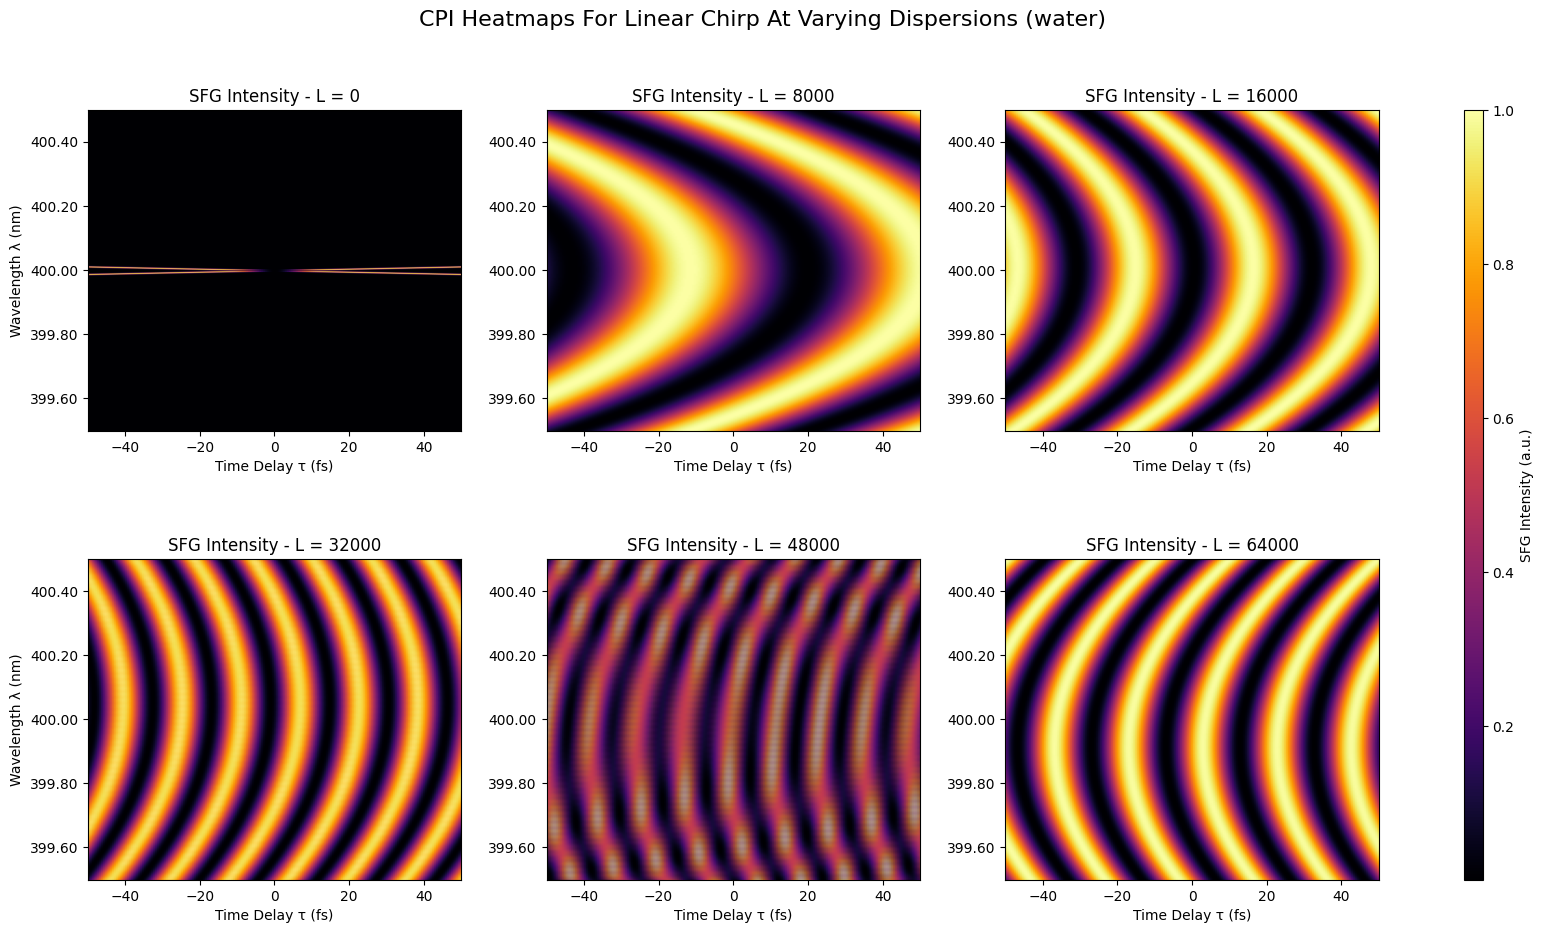

In [7]:

# --- Set up figure with GridSpec (2 rows x 3 columns + colorbar) ---
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05], height_ratios=[1, 1], wspace=0.3, hspace=0.4)

# Create 6 subplots in the 3x2 grid (rows 0 and 1, columns 0-2)
axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(3)]
#axes = [fig.add_subplot(gs[i]) for i in range(2) for j in range(3)]
#taus = np.arange(-50, 50+0.5, 0.5)
#extent = [taus[0], taus[-1], wavelengths[end], wavelengths[start]]

# --- Plot heatmaps ---
for ax, data, title in zip(axes, lin_CPIs, titles):

    extent = [taus[0], taus[-1], wavelengths[end], wavelengths[start]]

    im = ax.imshow(
        #data[:, start:end].T,
        data.T,
        extent=extent,
        origin='lower',
        aspect='auto',
        cmap='inferno'
    )
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(f'SFG Intensity - {title}')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Label the first plot in each row
axes[0].set_ylabel('Wavelength λ (nm)')
axes[3].set_ylabel('Wavelength λ (nm)')

# --- Add colorbar in its own column (on the right) ---
cbar_ax = fig.add_subplot(gs[:, 3])  # spans both rows
fig.colorbar(im, cax=cbar_ax, label='SFG Intensity (a.u.)')

fig.suptitle("CPI Heatmaps For Linear Chirp At Varying Dispersions (water)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.96, 0.96])  # leave room for colorbar and title
plt.show()

In [8]:
from scipy.optimize import least_squares

linear_dip_widths = []
erf_dip_widths = []
super_erf_dip_widths = []

# --- Initial guesses ---


def one_minus_gaussian(t, t_0, a1, a2, fwhm):
    return a1 - a2*np.exp(-4*np.log(2)*((t - t_0)**2)/fwhm**2)

def chisq(params, t, y):
    t0, a1, a2, fwhm = params
    model = one_minus_gaussian(t, t0, a1, a2, fwhm)
    return np.sum((y - model)**2)

def residuals(params, t, y):
    T0, a1, a2, sigma = params
    model = (a1 - a2 * np.exp(-4 * np.log(2) * (t - T0)**2 / sigma**2))
    return model - y

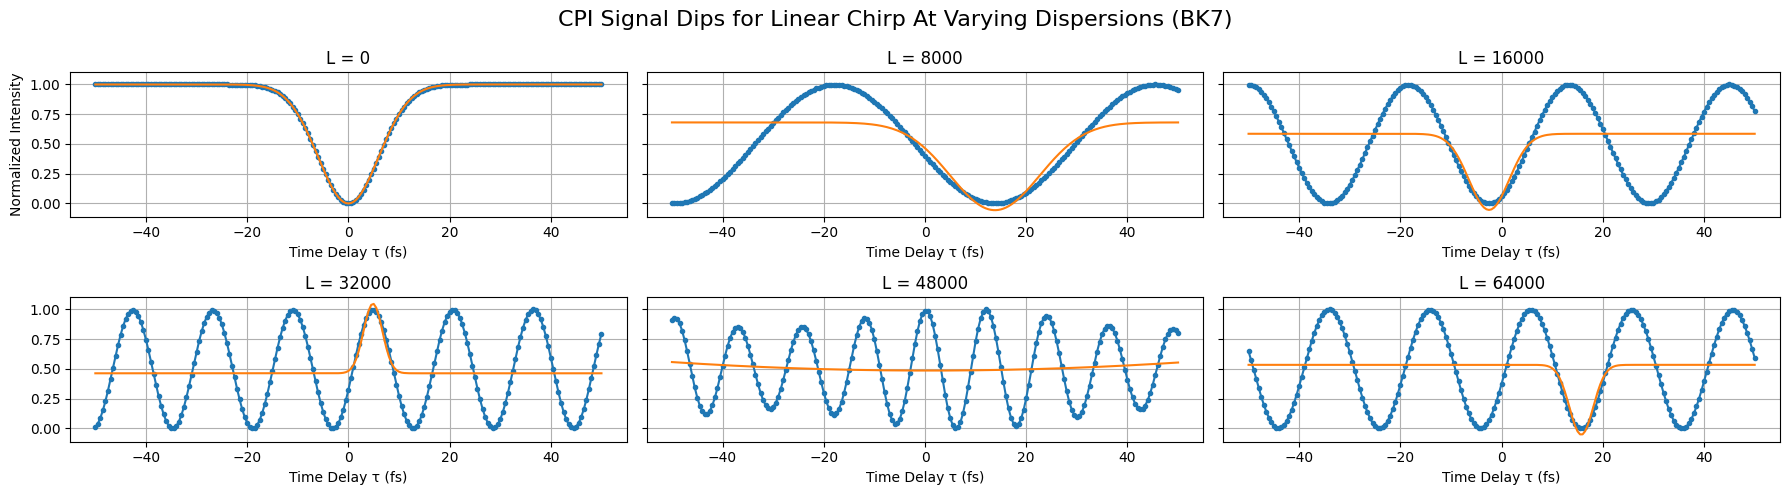

In [9]:
lin_signals = []
lin_curves = []

for dip, L in zip(lin_CPIs, Ls):
    init_guess = [0.0002*L, 0.0025, 0.9, 10]

    SFG_band = dip
    signal_vs_tau = np.sum(SFG_band, axis=1)  # integrate over wavelength axis
    signal_vs_tau_norm = (signal_vs_tau - np.min(signal_vs_tau))/(np.max(signal_vs_tau) - np.min(signal_vs_tau))
    lin_signals.append(signal_vs_tau_norm)

    
    lin_result = least_squares(residuals, init_guess, args=(taus, signal_vs_tau_norm), method='lm', 
                                ftol=1e-15, xtol=1e-15, gtol=1e-15)
    params = lin_result.x

    lin_curves.append(one_minus_gaussian(taus, params[0], params[1], params[2], params[3]))
    

#complete_titles = ["Linear CPI", "ERF CPI", "Super ERF CPI", "Linear CPI - Parabolic", "ERF CPI - Parabolic", "Super ERF CPI - Parbolic"]
# --- Create subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

axes = axes.flatten()

for ax, signal, curve, name in zip(axes, lin_signals, lin_curves, titles):
    ax.plot(taus, signal, marker=".")
    ax.plot(taus, curve)
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(name)
    ax.grid(True)

    # --- Optional: print fitted parameters ---
    #print(f"Fitted parameters for {name}: a = {param[0]:.4f}, t0 = {param[1]:.4f} fs, FWHM = {param[2]:.4f} fs")
    
axes[0].set_ylabel('Normalized Intensity')
fig.suptitle("CPI Signal Dips for Linear Chirp At Varying Dispersions (BK7)", fontsize=16)
plt.tight_layout()
plt.show();

In [10]:
moving_taus = []
moving_CPI = []

moving_taus.append(np.arange(-50, 50.5, 0.5))

for i, L in enumerate(Ls):

    lin_cpi = CPI(Ec_lin, Ea_lin, ws, moving_taus[i], water_eps * L)
    signal_vs_tau = np.sum(lin_cpi[:, start:end], axis=1)

    # Find the τ value of the dip
    min_index = np.argmin(signal_vs_tau)
    tau_center = moving_taus[i][min_index]

    # Recenter τ range
    tau_window = 50
    taus = np.arange(tau_center - tau_window, tau_center + tau_window + 0.5, 0.5)
    moving_taus[i] = taus
    if i < (len(Ls) - 1):
        moving_taus.append(taus)

    # Recalculate CPI, now centered on the dip
    lin_cpi_centered = CPI(Ec_lin, Ea_lin, ws, taus, water_eps * L)
    lin_cpi_centered = lin_cpi_centered[:, start:end]
    moving_CPI.append(lin_cpi_centered/np.max(lin_cpi_centered))
    


KeyboardInterrupt: 

In [ ]:
print(len())

In [ ]:

# --- Set up figure with GridSpec (2 rows x 3 columns + colorbar) ---
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05], height_ratios=[1, 1], wspace=0.3, hspace=0.4)

# Create 6 subplots in the 3x2 grid (rows 0 and 1, columns 0-2)
axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(3)]
#axes = [fig.add_subplot(gs[i]) for i in range(2) for j in range(3)]
#taus = np.arange(-50, 50+0.5, 0.5)
#extent = [taus[0], taus[-1], wavelengths[end], wavelengths[start]]

# --- Plot heatmaps ---
for ax, data, title, taus in zip(axes, moving_CPI, titles, moving_taus):

    extent = [taus[0], taus[-1], wavelengths[end], wavelengths[start]]

    im = ax.imshow(
        #data[:, start:end].T,
        data.T,
        extent=extent,
        origin='lower',
        aspect='auto',
        cmap='inferno'
    )
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(f'SFG Intensity - {title}')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Label the first plot in each row
axes[0].set_ylabel('Wavelength λ (nm)')
axes[3].set_ylabel('Wavelength λ (nm)')

# --- Add colorbar in its own column (on the right) ---
cbar_ax = fig.add_subplot(gs[:, 3])  # spans both rows
fig.colorbar(im, cax=cbar_ax, label='SFG Intensity (a.u.)')

fig.suptitle("CPI Heatmaps For Linear Chirp At Varying Dispersions (water)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.96, 0.96])  # leave room for colorbar and title
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x0000023E21C68C20> (for post_execute), with arguments args (),kwargs {}:


C:\Users\Berjoska\AppData\Local\Temp\ipykernel_9716\1128549352.py:29: UserWarning: Adding colorbar to a different Figure <Figure size 1800x1000 with 13 Axes> than <Figure size 1800x1000 with 7 Axes> which fig.colorbar is called on.
  fig.colorbar(im, cax=cbar_ax, label='SFG Intensity (a.u.)')
C:\Users\Berjoska\AppData\Local\Temp\ipykernel_9716\1128549352.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.96, 0.96])  # leave room for colorbar and title


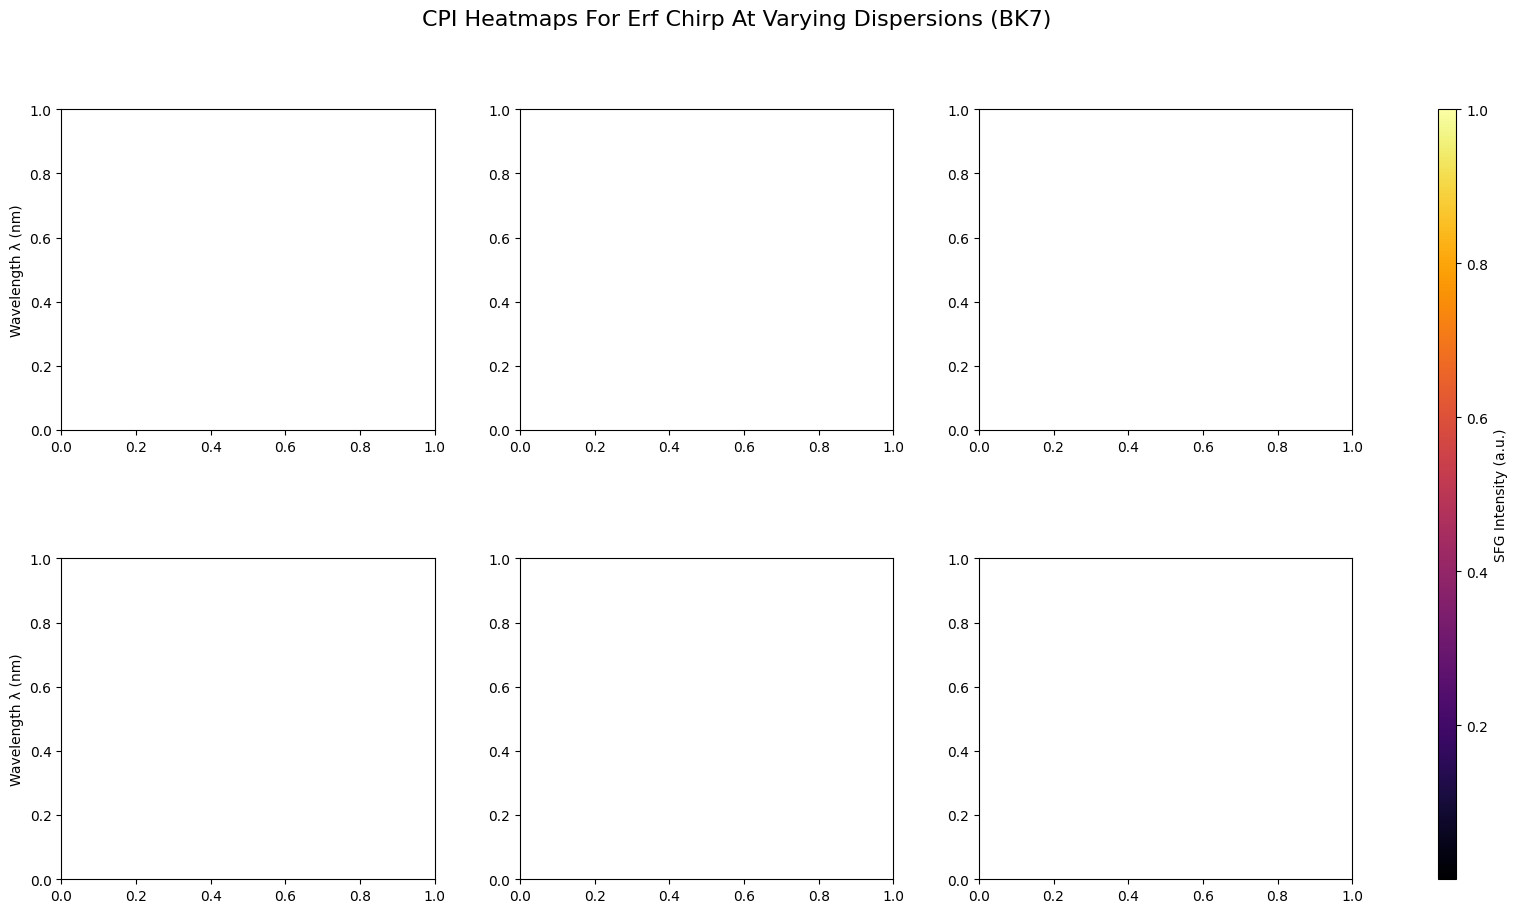

In [ ]:
# --- Set up figure with GridSpec (2 rows x 3 columns + colorbar) ---
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05], height_ratios=[1, 1], wspace=0.3, hspace=0.4)

# Create 6 subplots in the 3x2 grid (rows 0 and 1, columns 0-2)
axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(3)]

extent = [taus[0], taus[-1], wavelengths[end], wavelengths[start]]

# --- Plot heatmaps ---
for ax, data, title in zip(axes, erf_CPIs, titles):
    im = ax.imshow(
        data.T,
        extent=extent,
        origin='lower',
        aspect='auto',
        cmap='inferno'
    )
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(f'SFG Intensity - {title}')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Label the first plot in each row
axes[0].set_ylabel('Wavelength λ (nm)')
axes[3].set_ylabel('Wavelength λ (nm)')

# --- Add colorbar in its own column (on the right) ---
cbar_ax = fig.add_subplot(gs[:, 3])  # spans both rows
fig.colorbar(im, cax=cbar_ax, label='SFG Intensity (a.u.)')

fig.suptitle("CPI Heatmaps For Erf Chirp At Varying Dispersions (BK7)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.96, 0.96])  # leave room for colorbar and title
plt.show()

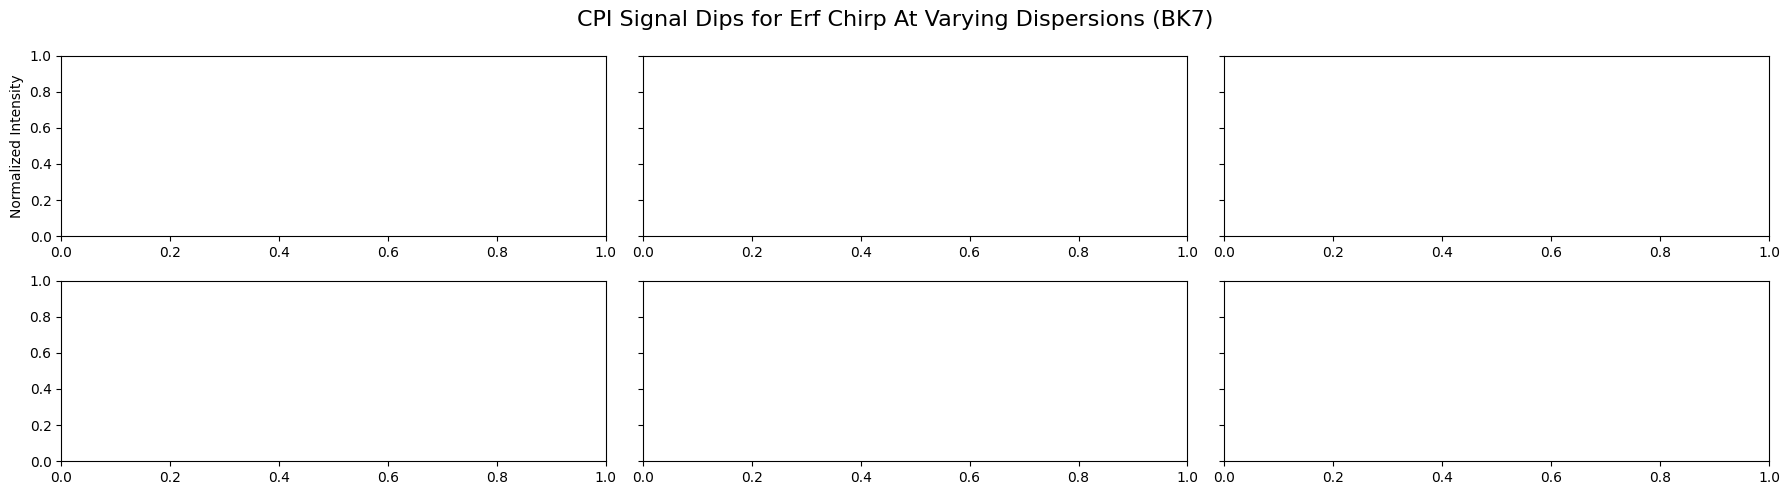

In [ ]:
erf_signals = []

for dip in erf_CPIs:
    SFG_band = dip
    signal_vs_tau = np.sum(SFG_band, axis=1)  # integrate over wavelength axis
    signal_vs_tau_norm = (signal_vs_tau - np.min(signal_vs_tau))/(np.max(signal_vs_tau) - np.min(signal_vs_tau))
    erf_signals.append(signal_vs_tau_norm)

    '''
    lin_result = least_squares(residuals, init_guess_parabolic, args=(taus, ), method='lm', 
                                ftol=1e-15, xtol=1e-15, gtol=1e-15)
    '''

#complete_titles = ["Linear CPI", "ERF CPI", "Super ERF CPI", "Linear CPI - Parabolic", "ERF CPI - Parabolic", "Super ERF CPI - Parbolic"]
# --- Create subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

axes = axes.flatten()

for ax, signal, name in zip(axes, erf_signals, titles):
    ax.plot(taus, signal)
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(name)
    ax.grid(True)

    # --- Optional: print fitted parameters ---
    #print(f"Fitted parameters for {name}: a = {param[0]:.4f}, t0 = {param[1]:.4f} fs, FWHM = {param[2]:.4f} fs")
    
axes[0].set_ylabel('Normalized Intensity')
fig.suptitle("CPI Signal Dips for Erf Chirp At Varying Dispersions (BK7)", fontsize=16)
plt.tight_layout()
plt.show();

C:\Users\Berjoska\AppData\Local\Temp\ipykernel_9716\3376463845.py:29: UserWarning: Adding colorbar to a different Figure <Figure size 1800x1000 with 13 Axes> than <Figure size 1800x1000 with 7 Axes> which fig.colorbar is called on.
  fig.colorbar(im, cax=cbar_ax, label='SFG Intensity (a.u.)')
C:\Users\Berjoska\AppData\Local\Temp\ipykernel_9716\3376463845.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.96, 0.96])  # leave room for colorbar and title


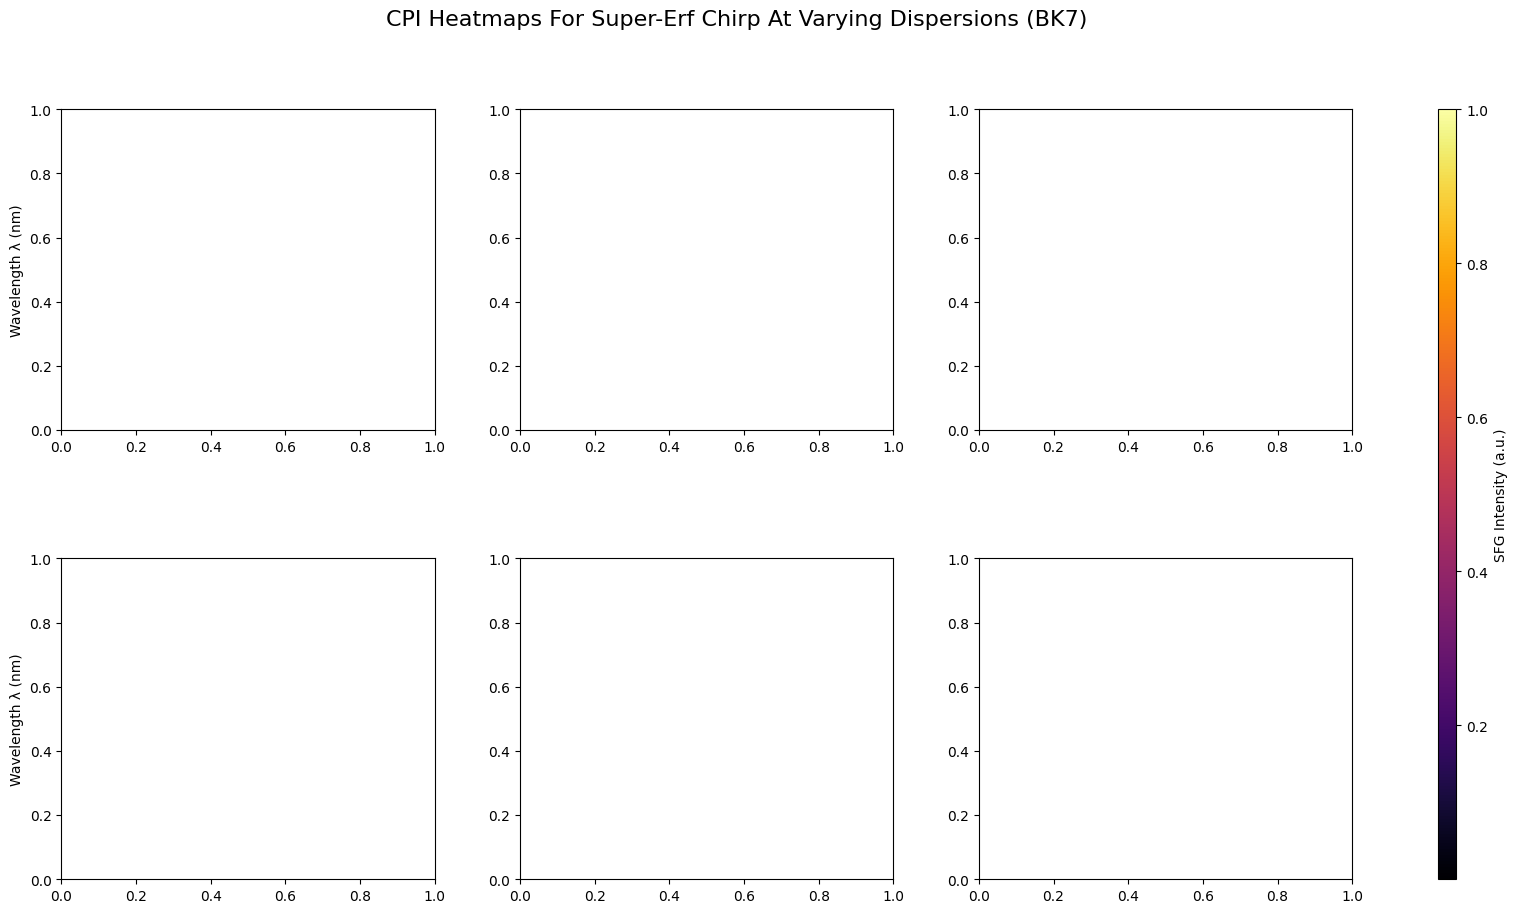

In [ ]:
# --- Set up figure with GridSpec (2 rows x 3 columns + colorbar) ---
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.05], height_ratios=[1, 1], wspace=0.3, hspace=0.4)

# Create 6 subplots in the 3x2 grid (rows 0 and 1, columns 0-2)
axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(3)]

extent = [taus[0], taus[-1], wavelengths[end], wavelengths[start]]

# --- Plot heatmaps ---
for ax, data, title in zip(axes, superf_CPIs, titles):
    im = ax.imshow(
        data.T,
        extent=extent,
        origin='lower',
        aspect='auto',
        cmap='inferno'
    )
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(f'SFG Intensity - {title}')
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Label the first plot in each row
axes[0].set_ylabel('Wavelength λ (nm)')
axes[3].set_ylabel('Wavelength λ (nm)')

# --- Add colorbar in its own column (on the right) ---
cbar_ax = fig.add_subplot(gs[:, 3])  # spans both rows
fig.colorbar(im, cax=cbar_ax, label='SFG Intensity (a.u.)')

fig.suptitle("CPI Heatmaps For Super-Erf Chirp At Varying Dispersions (BK7)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.96, 0.96])  # leave room for colorbar and title
plt.show()

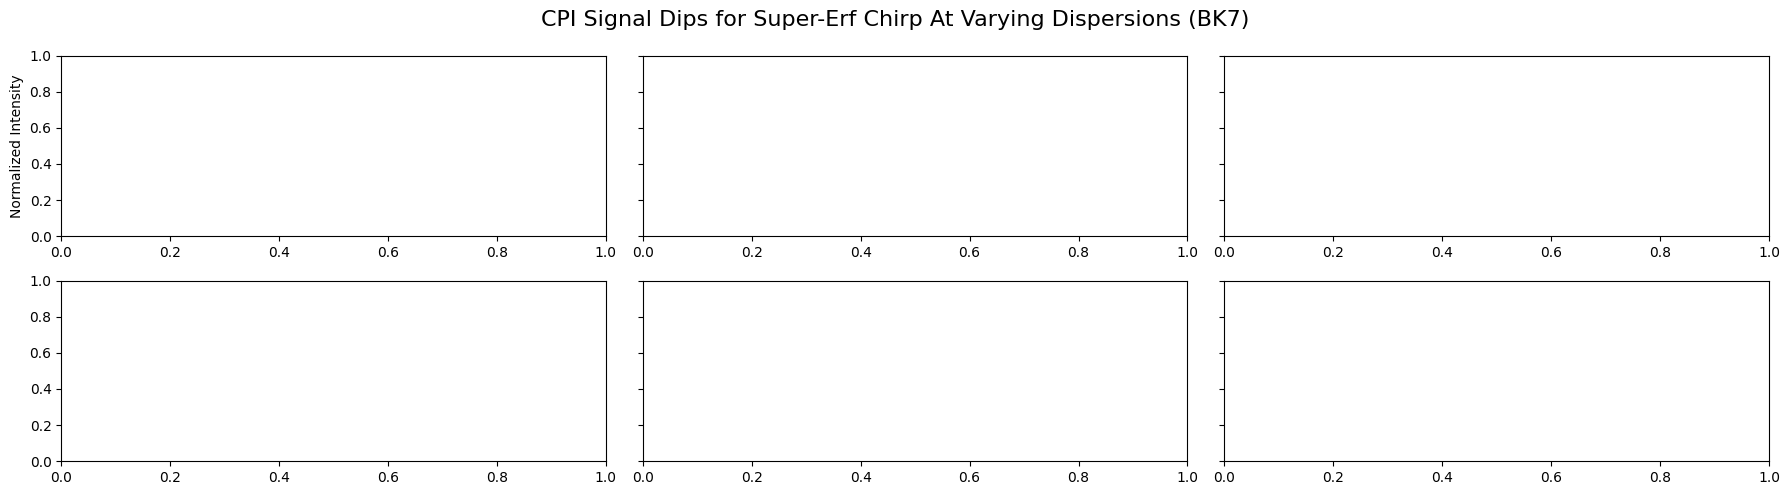

In [ ]:
superf_signals = []

for dip in superf_CPIs:
    SFG_band = dip
    signal_vs_tau = np.sum(SFG_band, axis=1)  # integrate over wavelength axis
    signal_vs_tau_norm = (signal_vs_tau - np.min(signal_vs_tau))/(np.max(signal_vs_tau) - np.min(signal_vs_tau))
    superf_signals.append(signal_vs_tau_norm)

    '''
    lin_result = least_squares(residuals, init_guess_parabolic, args=(taus, ), method='lm', 
                                ftol=1e-15, xtol=1e-15, gtol=1e-15)
    '''

#complete_titles = ["Linear CPI", "ERF CPI", "Super ERF CPI", "Linear CPI - Parabolic", "ERF CPI - Parabolic", "Super ERF CPI - Parbolic"]
# --- Create subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

axes = axes.flatten()

for ax, signal, name in zip(axes, superf_signals, titles):
    ax.plot(taus, signal)
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(name)
    ax.grid(True)

    # --- Optional: print fitted parameters ---
    #print(f"Fitted parameters for {name}: a = {param[0]:.4f}, t0 = {param[1]:.4f} fs, FWHM = {param[2]:.4f} fs")
    
axes[0].set_ylabel('Normalized Intensity')
fig.suptitle("CPI Signal Dips for Super-Erf Chirp At Varying Dispersions (BK7)", fontsize=16)
plt.tight_layout()
plt.show();

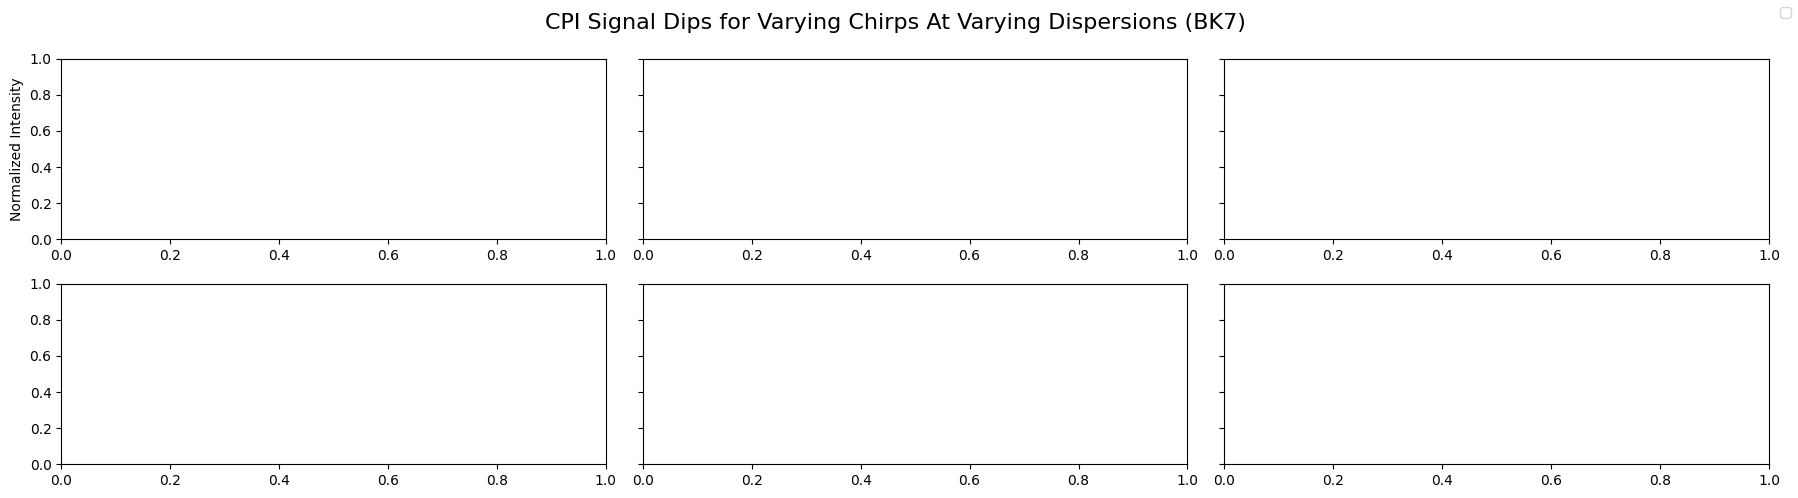

In [ ]:
# --- Create subplots ---
fig, axes = plt.subplots(2, 3, figsize=(18, 5), sharey=True)

axes = axes.flatten()

for ax, lin, erf, superf, name in zip(axes, lin_signals, erf_signals, superf_signals, titles):
    ax.plot(taus, lin, label = 'Linear Chirp')
    ax.plot(taus, erf, label = 'Erf Chirp')
    ax.plot(taus, superf, label = 'Super-Erf Chirp')
    ax.set_xlabel('Time Delay τ (fs)')
    ax.set_title(name)
    ax.grid(True)

    # --- Optional: print fitted parameters ---
    #print(f"Fitted parameters for {name}: a = {param[0]:.4f}, t0 = {param[1]:.4f} fs, FWHM = {param[2]:.4f} fs")

handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
axes[0].set_ylabel('Normalized Intensity')
fig.suptitle("CPI Signal Dips for Varying Chirps At Varying Dispersions (BK7)", fontsize=16)
plt.tight_layout()
plt.show();

In [ ]:


for lin, erf, superf in zip(lin_signals, erf_signals, superf_signals):
 
    #pretty sure maggies code uses the LevenbergMarquardt method, at least for the 0 dispersion dip
    lin_result = least_squares(residuals, init_guess, args=(taus, lin), method='lm', 
                               ftol=1e-15, xtol=1e-15, gtol=1e-15)
    erf_result = least_squares(residuals, init_guess, args=(taus, erf), method='lm',
                               ftol=1e-15, xtol=1e-15, gtol=1e-15)
    superf_result = least_squares(residuals, init_guess, args=(taus, superf), method='lm', 
                               ftol=1e-15, xtol=1e-15, gtol=1e-15)

    if (L == 0):
        print(np.sum(lin_result.fun**2))
        print(np.sum(erf_result.fun**2))
        print(np.sum(superf_result.fun**2))
    
    linear_dip_widths.append(lin_result.x[3])
    erf_dip_widths.append(erf_result.x[3])
    super_erf_dip_widths.append(superf_result.x[3]) 

print(linear_dip_widths[0])
print(erf_dip_widths[0])
print(super_erf_dip_widths[0])
np.savetxt(f"./linear_dip_widths.txt", linear_dip_widths, )
plt.plot(Ls, linear_dip_widths, label = "linear")
plt.plot(Ls, erf_dip_widths, label = "erf")
plt.plot(Ls, super_erf_dip_widths, label = "super-erf")
plt.ylim(0, 30)

IndexError: list index out of range